Proof of concept for comparing expected and predicted return


#Setup
Import libraries and load data


In [ ]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from dateutil.relativedelta import relativedelta
from datetime import datetime

In [ ]:
#Note: financial ratio data collected near end of month
#Currently available from 2010 - 2023
financial_ratio_df = pd.read_csv("/content/Nasdaq Financial Ratios.csv")
financial_ratio_df = financial_ratio_df.drop(columns=['adate', 'qdate'])

#Very Basic Model

In [ ]:
class FinRatioModel:
  def __init__(self, ticker):
    self.ticker = ticker
    if (financial_ratio_df['TICKER'] == self.ticker).any():
        self.has_ticker = True
        self.init_ratio_data()
        cols_to_delete = ['permno', 'divyield', 'TICKER', 'public_date']
        self.ratio_names = [col for col in list(self.ratio_data.columns)  if col not in cols_to_delete]

    else:
        print(f"Data unavailable for {self.ticker}")
        self.has_ticker = False

  def init_ratio_data(self):
    self.ratio_data = financial_ratio_df[financial_ratio_df['TICKER'] == self.ticker]

  def get_return_data(self, start_date, end_date):
    stock_df = yf.download(self.ticker, start=start_date, end=end_date)
    #Get end of month dataa
    stock_df = stock_df.resample('M').last()
    stock_df["Return"] = stock_df["Close"].pct_change()
    return stock_df

  """
  retrain_period: retrain the model with new data every <retrain_period> months
  lookback_period: how many months to look back in time when training the model
  start_date/end_date: dates to run the backtest on, range must be greater than lookback_period
  """

  def backtest(self, retrain_period, lookback_period, start_date, end_date, graph_results):
    if not self.has_ticker:
      print("Missing data, can't backtest")
      return

    results_df = pd.DataFrame(columns=['date', 'pred_return', 'expect_return'])
    ratio_df = self.ratio_data[(self.ratio_data['public_date'] >= start_date) & (self.ratio_data['public_date'] <= end_date)]
    ratio_df = ratio_df.reset_index(drop=True)
    return_df = self.get_return_data(start_date, end_date)
    return_df = return_df.reset_index()

    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    num_months = relativedelta(end, start).months

    #Get results monthly
    for month in range(lookback_period+1, num_months, 1):

      #Retrain the model
      if (month - (lookback_period+1)) % retrain_period == 0:
        print(f"Month {month}: retraining model")
        X_train = ratio_df.loc[month - lookback_period:month-1, self.ratio_names]
        y_train = return_df.loc[month - lookback_period:month-1, ["Return"]]

        #training model
        model = sm.OLS(y_train, X_train).fit()

      y_expected = return_df.loc[month, ["Return"]]
      y_pred = model.predict(ratio_df.loc[month, self.ratio_names])

      new_row = pd.DataFrame([{
        'date': ratio_df.loc[month, 'public_date'],
        'expect_return': y_expected,
        'pred_return': y_pred,
      }])
      results_df = pd.concat([results_df, new_row])

    if graph_results:
      self.graph_results(results_df)

    return results_df

  def graph_results(self, returns_df):
    dates = returns_df["date"]
    plt.figure(figsize=(10, 6))
    plt.plot(dates, returns_df['pred_return'], marker='o', label='Predicted Returns')
    plt.plot(dates, returns_df['expect_return'], marker='o', label='Expected Returns')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.title('Expected vs. Predicted Returns')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
start_date = '2023-01-01'
end_date = '2023-12-01'
retrain_period = 3
lookback_period = 5

#Test

[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


6 : retraining
9 : retraining


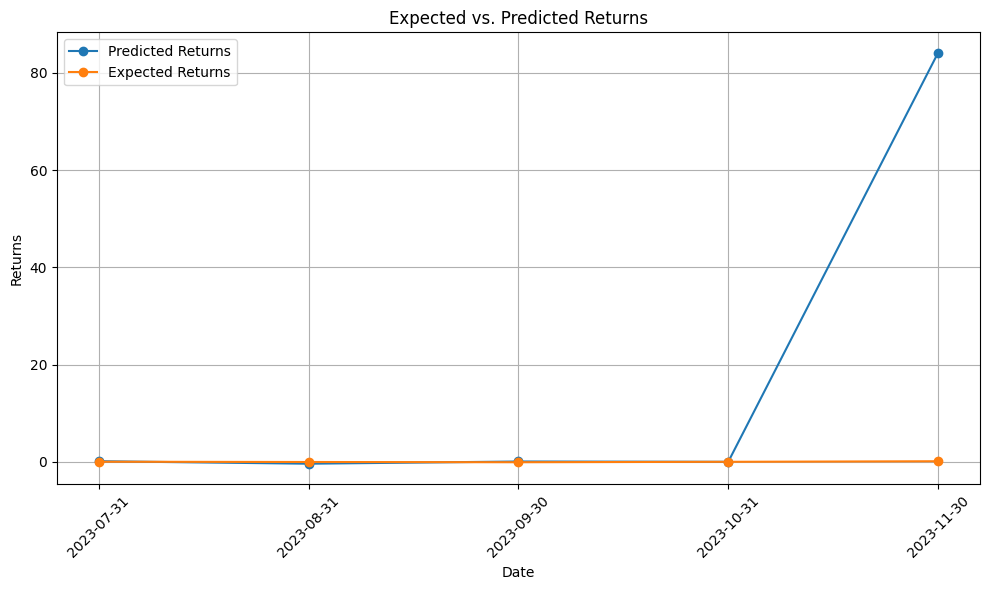

In [ ]:
test_ticker = "AAPL"
model = FinRatioModel(test_ticker)
results = model.backtest(retrain_period, lookback_period, start_date, end_date, graph_results=True)

#Not sure what's happening with the final month, possibly missing data, data was not cleaned before processing

In [ ]:
results

,date,pred_return,expect_return
0,2023-07-31,None 0.118021 dtype: object,"Return 0.012785 Name: 6, dtype: object"
0,2023-08-31,None -0.396162 dtype: object,"Return -0.043675 Name: 7, dtype: object"
0,2023-09-30,None 0.059611 dtype: object,"Return -0.088678 Name: 8, dtype: object"
0,2023-10-31,None -0.004721 dtype: object,"Return -0.00257 Name: 9, dtype: object"
0,2023-11-30,None 84.116603 dtype: object,"Return 0.112315 Name: 10, dtype: object"
